2.16.2
3.4.1


sh: nvidia-smi: command not found


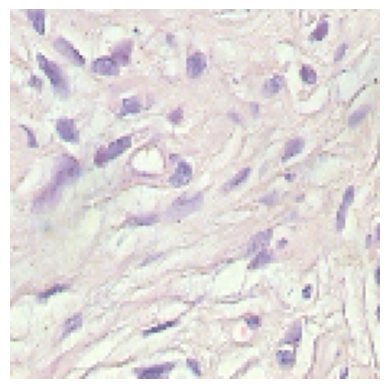

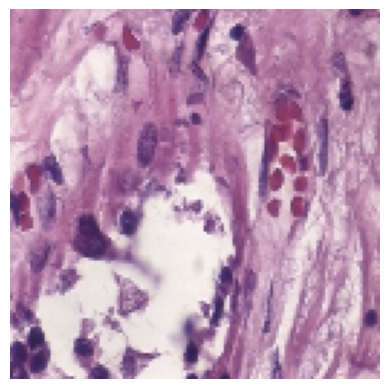

(7909, 2)
                                             image target
0  augmented/benign/SOB_B_F-14-23060CD-100-001.png      0
1  augmented/benign/SOB_B_TA-14-19854C-200-016.png      0
2  augmented/benign/SOB_B_TA-14-19854C-200-002.png      0
3    augmented/benign/SOB_B_F-14-25197-400-039.png      0
4   augmented/benign/SOB_B_F-14-14134E-100-007.png      0
target
1    5429
0    2480
Name: count, dtype: int64
target
1    5429
0    5429
Name: count, dtype: int64


100%|████████████████████████████████████| 10858/10858 [01:05<00:00, 165.89it/s]


(9773, 128, 128, 3)
(977, 128, 128, 3)
(108, 128, 128, 3)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step


/opt/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.632409, acc.: 62.50%] [G loss: 0.636317]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
10 [D loss: 0.575681, acc.: 47.02%] [G loss: 0.611082]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
20 [D loss: 0.565966, acc.: 44.51%] [G loss: 0.606411]

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Flatten, Conv2D, Dropout, BatchNormalization, Activation, Input, UpSampling2D, ZeroPadding2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications import VGG16
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import os
from tqdm import tqdm
import shutil
import itertools
import time

# Print TensorFlow and Keras versions
print(tf.__version__)
print(tf.keras.__version__)

# Check GPU status
os.system('nvidia-smi')

# Callbacks
epochs = 50

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=epochs, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_delta=0.0001)
csv_logger = CSVLogger('Model.log')
callbacks = [earlystop, csv_logger, reduce_lr]

# Intersection over Union (IoU)
def iou(y_true, y_pred, smooth=0.5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    sum_ = tf.reduce_sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# Computing Sensitivity
def sensitivity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + tf.keras.backend.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + tf.keras.backend.epsilon())

def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1_val

def dice_coefficient(y_true, y_pred, epsilon=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_flat = tf.reshape(y_true, [-1])
    y_pred_flat = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    dice_score = (2.0 * intersection + epsilon) / (tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat) + epsilon)
    return dice_score

def tversky(y_true, y_pred, smooth=1, alpha=0.7):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true_pos = tf.keras.backend.flatten(y_true)
    y_pred_pos = tf.keras.backend.flatten(y_pred)
    true_pos = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1 - y_pred_pos))
    false_pos = tf.reduce_sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    tv = tversky(y_true, y_pred)
    return tf.keras.backend.pow((1 - tv), gamma)

def confusion_matrix_img(y_pred, y_true, savename):
    cm = confusion_matrix(y_true, y_pred)
    labels = ['benign', 'malignant']
    title = 'Confusion matrix'
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(savename)
    plt.show()

# Create directories for augmented data
size = 128
os.makedirs('augmented/benign', exist_ok=True)
os.makedirs('augmented/malignant', exist_ok=True)

def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles.extend(getListOfFiles(fullPath))  # Recursive call
        else:
            allFiles.append(fullPath)
    return allFiles

# Copy benign images to the augmented directory
files_benign = getListOfFiles('/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign')
for f in files_benign:
    if f.endswith('.png'):
        shutil.copy(f, 'augmented/benign')

# Copy malignant images to the augmented directory
files_malignant = getListOfFiles('/Users/renitalewis/Downloads/archive/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/malignant')
for f in files_malignant:
    if f.endswith('.png'):
        shutil.copy(f, 'augmented/malignant')

benign_images = getListOfFiles('augmented/benign')
malignant_images = getListOfFiles('augmented/malignant')

# Load and display an image
image_path = benign_images[9]
img = load_img(image_path, target_size=(size, size), color_mode='rgb')
img_array = img_to_array(img)
plt.imshow(img_array.astype('uint8'))
plt.axis('off')
plt.show()

# Load and display another image
image_path = malignant_images[45]
img = load_img(image_path, target_size=(size, size), color_mode='rgb')
img_array = img_to_array(img)
plt.imshow(img_array.astype('uint8'))
plt.axis('off')
plt.show()

# Prepare the DataFrame
total_images = len(benign_images) + len(malignant_images)
data = pd.DataFrame(index=np.arange(0, total_images), columns=["image", "target"])

k = 0
for c, image_list in enumerate([benign_images, malignant_images]):
    for image_path in image_list:
        data.loc[k, "image"] = image_path
        data.loc[k, "target"] = c
        k += 1

print(data.shape)
print(data.head())
count_data = data["target"].value_counts()
print(count_data)
ben_upsampled = resample(data[data['target'] == 0], n_samples=data[data['target'] == 1].shape[0], random_state=42)
up_sampled = pd.concat([data[data['target'] == 1], ben_upsampled])
print(up_sampled['target'].value_counts())

kf = KFold(n_splits=10, random_state=42, shuffle=True)

# Corrected loop to load images
train_image = []
y = []

for i in tqdm(range(up_sampled.shape[0])):
    img = tf.keras.utils.load_img(up_sampled['image'].iloc[i], target_size=(size, size), color_mode='rgb')
    img = tf.keras.utils.img_to_array(img)
    img = img / 255.0
    train_image.append(img)
        
X = np.array(train_image)
y = up_sampled.iloc[:, -1].values

# KFold split
kf = KFold(n_splits=10, random_state=42, shuffle=True)

for train_index, test_index in kf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

for train_index, test_index in kf.split(X_test, y_test):
    X2_test, X_val, y2_test, y_val = X_test[train_index], X_test[test_index], y_test[train_index], y_test[test_index]

Y_train = to_categorical(y_train, 2)
Y_test = to_categorical(y2_test, 2)
Y_val = to_categorical(y_val, 2)

print(X_train.shape)
print(X2_test.shape)
print(X_val.shape)

data_gen = ImageDataGenerator(
        zoom_range=1.2,  # set range for random zoom
        rotation_range=90,
        width_shift_range=0.5,
        height_shift_range=0.5,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )
data_gen.fit(X_train)
data_gen.fit(X_val)
data_gen.fit(X2_test)

# Define the discriminator model
def build_discriminator(img_shape):
    model = Sequential()
    
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same", input_shape=img_shape))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(negative_slope=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

# Define the generator model
def build_generator(latent_dim, img_shape):
    model = Sequential()
    
    model.add(Dense(128 * 8 * 8, activation="relu", input_dim=latent_dim))
    model.add(Reshape((8, 8, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(32, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(img_shape[2], kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    
    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

# Define the combined model
def build_combined(discriminator, generator):
    discriminator.trainable = False
    z = Input(shape=(latent_dim,))
    img = generator(z)
    validity = discriminator(img)
    return Model(z, validity)

latent_dim = 100
img_shape = (size, size, 3)

# Build and compile the discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

# Build the generator
generator = build_generator(latent_dim, img_shape)

# Build the combined model
combined = build_combined(discriminator, generator)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

# Training the GAN
epochs = 100
batch_size = 16
save_interval = 10

# Create the "images" directory if it doesn't exist
os.makedirs('images', exist_ok=True)

# Load and preprocess the dataset
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Labels for real and fake images
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of real images
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Generate a half batch of fake images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid)

    # Print the progress
    if epoch % 10 == 0:
        d_loss_value = np.mean(d_loss)
        d_acc_value = 100 * d_loss_real[1]
        g_loss_value = np.mean(g_loss)
        print(f"{epoch} [D loss: {d_loss_value:.6f}, acc.: {d_acc_value:.2f}%] [G loss: {g_loss_value:.6f}]")

    # If at save interval => save generated image samples
    if epoch % save_interval == 0:
        noise = np.random.normal(0, 1, (25, latent_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5, 5)
        cnt = 0
        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[cnt, :, :, :])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)
        plt.close()


In [3]:
# Using VGG-16 for feature extraction
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(size, size, 3))
for layer in vgg16.layers:
    layer.trainable = False

# Adding custom layers on top of VGG-16
x = vgg16.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs=vgg16.input, outputs=predictions)

# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='AUC'),
                       f1_score, specificity, sensitivity, iou, tversky])

print(model.input_shape)
print(model.output_shape)
model.summary()

# Measure the training time using the time module
import time
start_time = time.time()
history = model.fit(data_gen.flow(X_train, Y_train,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=True),
                    callbacks=callbacks,
                    epochs=50,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    validation_data=data_gen.flow(X_val, Y_val,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=True))
end_time = time.time()

print("Training time: {:.2f} seconds".format(end_time - start_time))
model.save("modelBH.h5")
print("Saved model to disk")

df = pd.DataFrame(history.history) 
df.to_excel("output.xlsx")
df.head(50)

(None, 128, 128, 3)
(None, 2)


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           51

 Total params: 16,878,402 (64.39 MB)

 Trainable params: 2,163,714 (8.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


610/610 ━━━━━━━━━━━━━━━━━━━━ 310s 506ms/step - AUC: 0.5003 - accuracy: 0.4989 - f1_score: 0.4988 - iou: 0.3503 - loss: 0.7900 - precision: 0.4989 - recall: 0.4989 - sensitivity: 0.4988 - specificity: 0.4988 - tversky: 0.5317 - val_AUC: 0.4239 - val_accuracy: 0.4167 - val_f1_score: 0.4167 - val_iou: 0.3463 - val_loss: 0.6963 - val_precision: 0.4167 - val_recall: 0.4167 - val_sensitivity: 0.4167 - val_specificity: 0.4167 - val_tversky: 0.5293 - learning_rate: 0.0010
Epoch 2/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 5:09 509ms/step - AUC: 0.4023 - accuracy: 0.3750 - f1_score: 0.3750 - iou: 0.3462 - loss: 0.6949 - precision: 0.3750 - recall: 0.3750 - sensitivity: 0.3750 - specificity: 0.3750 - tversky: 0.5286

2024-07-16 22:14:56.049248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.4023 - accuracy: 0.3750 - f1_score: 0.1878 - iou: 0.1734 - loss: 0.6949 - precision: 0.3750 - recall: 0.3750 - sensitivity: 0.1878 - specificity: 0.1878 - tversky: 0.2647 - val_AUC: 0.3573 - val_accuracy: 0.3889 - val_f1_score: 0.3899 - val_iou: 0.3448 - val_loss: 0.6998 - val_precision: 0.3889 - val_recall: 0.3889 - val_sensitivity: 0.3899 - val_specificity: 0.3899 - val_tversky: 0.5277 - learning_rate: 0.0010
Epoch 3/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 336s 551ms/step - AUC: 0.5027 - accuracy: 0.5080 - f1_score: 0.5079 - iou: 0.3470 - loss: 0.6932 - precision: 0.5080 - recall: 0.5080 - sensitivity: 0.5079 - specificity: 0.5079 - tversky: 0.5294 - val_AUC: 0.4705 - val_accuracy: 0.5000 - val_f1_score: 0.5030 - val_iou: 0.3469 - val_loss: 0.6951 - val_precision: 0.5000 - val_recall: 0.5000 - val_sensitivity: 0.5030 - val_specificity: 0.5030 - val_tversky: 0.5300 - learning_rate: 0.0010
Epoch 4/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 5:32 547ms/step

2024-07-16 22:20:36.519208: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.3125 - accuracy: 0.4375 - f1_score: 0.2191 - iou: 0.1731 - loss: 0.6960 - precision: 0.4375 - recall: 0.4375 - sensitivity: 0.2191 - specificity: 0.2191 - tversky: 0.2645 - val_AUC: 0.4429 - val_accuracy: 0.4722 - val_f1_score: 0.4702 - val_iou: 0.3467 - val_loss: 0.6958 - val_precision: 0.4722 - val_recall: 0.4722 - val_sensitivity: 0.4702 - val_specificity: 0.4702 - val_tversky: 0.5298 - learning_rate: 0.0010
Epoch 5/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 349s 572ms/step - AUC: 0.4918 - accuracy: 0.5013 - f1_score: 0.5013 - iou: 0.3469 - loss: 0.6933 - precision: 0.5013 - recall: 0.5013 - sensitivity: 0.5013 - specificity: 0.5013 - tversky: 0.5294 - val_AUC: 0.4761 - val_accuracy: 0.5093 - val_f1_score: 0.5000 - val_iou: 0.3464 - val_loss: 0.6958 - val_precision: 0.5093 - val_recall: 0.5093 - val_sensitivity: 0.5000 - val_specificity: 0.5000 - val_tversky: 0.5295 - learning_rate: 0.0010
Epoch 6/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 5:37 554ms/step

2024-07-16 22:26:29.908251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.6465 - accuracy: 0.6875 - f1_score: 0.3443 - iou: 0.1742 - loss: 0.6910 - precision: 0.6875 - recall: 0.6875 - sensitivity: 0.3443 - specificity: 0.3443 - tversky: 0.2657 - val_AUC: 0.3999 - val_accuracy: 0.3981 - val_f1_score: 0.4048 - val_iou: 0.3444 - val_loss: 0.7011 - val_precision: 0.3981 - val_recall: 0.3981 - val_sensitivity: 0.4048 - val_specificity: 0.4048 - val_tversky: 0.5273 - learning_rate: 0.0010
Epoch 7/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 355s 581ms/step - AUC: 0.5024 - accuracy: 0.4994 - f1_score: 0.4994 - iou: 0.3469 - loss: 0.6932 - precision: 0.4994 - recall: 0.4994 - sensitivity: 0.4994 - specificity: 0.4994 - tversky: 0.5294 - val_AUC: 0.4836 - val_accuracy: 0.4722 - val_f1_score: 0.4702 - val_iou: 0.3467 - val_loss: 0.6957 - val_precision: 0.4722 - val_recall: 0.4722 - val_sensitivity: 0.4702 - val_specificity: 0.4702 - val_tversky: 0.5297 - learning_rate: 0.0010
Epoch 8/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 5:39 558ms/step

2024-07-16 22:32:28.821426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.6719 - accuracy: 0.5625 - f1_score: 0.2817 - iou: 0.1742 - loss: 0.6909 - precision: 0.5625 - recall: 0.5625 - sensitivity: 0.2817 - specificity: 0.2817 - tversky: 0.2657 - val_AUC: 0.5036 - val_accuracy: 0.5000 - val_f1_score: 0.5030 - val_iou: 0.3477 - val_loss: 0.6927 - val_precision: 0.5000 - val_recall: 0.5000 - val_sensitivity: 0.5030 - val_specificity: 0.5030 - val_tversky: 0.5309 - learning_rate: 0.0010
Epoch 9/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 352s 577ms/step - AUC: 0.4907 - accuracy: 0.4962 - f1_score: 0.4964 - iou: 0.3469 - loss: 0.6932 - precision: 0.4962 - recall: 0.4962 - sensitivity: 0.4964 - specificity: 0.4964 - tversky: 0.5294 - val_AUC: 0.4437 - val_accuracy: 0.4630 - val_f1_score: 0.4673 - val_iou: 0.3461 - val_loss: 0.6970 - val_precision: 0.4630 - val_recall: 0.4630 - val_sensitivity: 0.4673 - val_specificity: 0.4673 - val_tversky: 0.5291 - learning_rate: 0.0010
Epoch 10/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 6:04 598ms/ste

2024-07-16 22:38:25.521412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.5000 - accuracy: 0.5625 - f1_score: 0.2817 - iou: 0.1738 - loss: 0.6929 - precision: 0.5625 - recall: 0.5625 - sensitivity: 0.2817 - specificity: 0.2817 - tversky: 0.2652 - val_AUC: 0.4570 - val_accuracy: 0.4537 - val_f1_score: 0.4583 - val_iou: 0.3466 - val_loss: 0.6959 - val_precision: 0.4537 - val_recall: 0.4537 - val_sensitivity: 0.4583 - val_specificity: 0.4583 - val_tversky: 0.5297 - learning_rate: 0.0010
Epoch 11/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 353s 579ms/step - AUC: 0.4867 - accuracy: 0.4841 - f1_score: 0.4842 - iou: 0.3469 - loss: 0.6934 - precision: 0.4841 - recall: 0.4841 - sensitivity: 0.4842 - specificity: 0.4842 - tversky: 0.5293 - val_AUC: 0.4535 - val_accuracy: 0.4907 - val_f1_score: 0.4792 - val_iou: 0.3469 - val_loss: 0.6948 - val_precision: 0.4907 - val_recall: 0.4907 - val_sensitivity: 0.4792 - val_specificity: 0.4792 - val_tversky: 0.5300 - learning_rate: 0.0010
Epoch 12/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 5:57 587ms/st

2024-07-16 22:44:23.154592: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.3359 - accuracy: 0.3750 - f1_score: 0.1878 - iou: 0.1730 - loss: 0.6967 - precision: 0.3750 - recall: 0.3750 - sensitivity: 0.1878 - specificity: 0.1878 - tversky: 0.2643 - val_AUC: 0.5733 - val_accuracy: 0.6019 - val_f1_score: 0.6131 - val_iou: 0.3490 - val_loss: 0.6909 - val_precision: 0.6019 - val_recall: 0.6019 - val_sensitivity: 0.6131 - val_specificity: 0.6131 - val_tversky: 0.5322 - learning_rate: 0.0010
Epoch 13/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 354s 581ms/step - AUC: 0.4901 - accuracy: 0.4829 - f1_score: 0.4829 - iou: 0.3469 - loss: 0.6934 - precision: 0.4829 - recall: 0.4829 - sensitivity: 0.4829 - specificity: 0.4829 - tversky: 0.5293 - val_AUC: 0.5761 - val_accuracy: 0.5370 - val_f1_score: 0.5357 - val_iou: 0.3488 - val_loss: 0.6909 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5357 - val_specificity: 0.5357 - val_tversky: 0.5320 - learning_rate: 0.0010
Epoch 14/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 5:44 566ms/st

2024-07-16 22:50:22.045579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.4551 - accuracy: 0.5000 - f1_score: 0.2504 - iou: 0.1737 - loss: 0.6934 - precision: 0.5000 - recall: 0.5000 - sensitivity: 0.2504 - specificity: 0.2504 - tversky: 0.2651 - val_AUC: 0.4742 - val_accuracy: 0.4907 - val_f1_score: 0.4881 - val_iou: 0.3468 - val_loss: 0.6955 - val_precision: 0.4907 - val_recall: 0.4907 - val_sensitivity: 0.4881 - val_specificity: 0.4881 - val_tversky: 0.5299 - learning_rate: 0.0010
Epoch 15/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 357s 585ms/step - AUC: 0.4935 - accuracy: 0.4870 - f1_score: 0.4870 - iou: 0.3469 - loss: 0.6932 - precision: 0.4870 - recall: 0.4870 - sensitivity: 0.4870 - specificity: 0.4870 - tversky: 0.5294 - val_AUC: 0.5011 - val_accuracy: 0.5093 - val_f1_score: 0.5149 - val_iou: 0.3480 - val_loss: 0.6930 - val_precision: 0.5093 - val_recall: 0.5093 - val_sensitivity: 0.5149 - val_specificity: 0.5149 - val_tversky: 0.5312 - learning_rate: 0.0010
Epoch 16/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 5:46 570ms/st

2024-07-16 22:56:23.544506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.5000 - accuracy: 0.4375 - f1_score: 0.2191 - iou: 0.1738 - loss: 0.6929 - precision: 0.4375 - recall: 0.4375 - sensitivity: 0.2191 - specificity: 0.2191 - tversky: 0.2652 - val_AUC: 0.5013 - val_accuracy: 0.4722 - val_f1_score: 0.4732 - val_iou: 0.3478 - val_loss: 0.6929 - val_precision: 0.4722 - val_recall: 0.4722 - val_sensitivity: 0.4732 - val_specificity: 0.4732 - val_tversky: 0.5310 - learning_rate: 0.0010
Epoch 17/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 571ms/step - AUC: 0.5040 - accuracy: 0.5118 - f1_score: 0.5119 - iou: 0.3470 - loss: 0.6931 - precision: 0.5118 - recall: 0.5118 - sensitivity: 0.5119 - specificity: 0.5119 - tversky: 0.5295
Epoch 17: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
610/610 ━━━━━━━━━━━━━━━━━━━━ 353s 578ms/step - AUC: 0.5040 - accuracy: 0.5118 - f1_score: 0.5119 - iou: 0.3470 - loss: 0.6931 - precision: 0.5118 - recall: 0.5118 - sensitivity: 0.5119 - specificity: 0.5119 - tversky: 0.52

2024-07-16 23:02:20.607738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.4062 - accuracy: 0.4375 - f1_score: 0.2191 - iou: 0.1732 - loss: 0.6960 - precision: 0.4375 - recall: 0.4375 - sensitivity: 0.2191 - specificity: 0.2191 - tversky: 0.2645 - val_AUC: 0.4289 - val_accuracy: 0.4722 - val_f1_score: 0.4821 - val_iou: 0.3457 - val_loss: 0.6984 - val_precision: 0.4722 - val_recall: 0.4722 - val_sensitivity: 0.4821 - val_specificity: 0.4821 - val_tversky: 0.5287 - learning_rate: 2.0000e-04
Epoch 19/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 355s 581ms/step - AUC: 0.5005 - accuracy: 0.5037 - f1_score: 0.5037 - iou: 0.3470 - loss: 0.6932 - precision: 0.5037 - recall: 0.5037 - sensitivity: 0.5037 - specificity: 0.5037 - tversky: 0.5294 - val_AUC: 0.4504 - val_accuracy: 0.4259 - val_f1_score: 0.4345 - val_iou: 0.3470 - val_loss: 0.6957 - val_precision: 0.4259 - val_recall: 0.4259 - val_sensitivity: 0.4345 - val_specificity: 0.4345 - val_tversky: 0.5300 - learning_rate: 2.0000e-04
Epoch 20/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 5:40 

2024-07-16 23:08:19.680139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.4375 - accuracy: 0.4375 - f1_score: 0.2191 - iou: 0.1736 - loss: 0.6940 - precision: 0.4375 - recall: 0.4375 - sensitivity: 0.2191 - specificity: 0.2191 - tversky: 0.2649 - val_AUC: 0.4732 - val_accuracy: 0.4537 - val_f1_score: 0.4583 - val_iou: 0.3476 - val_loss: 0.6939 - val_precision: 0.4537 - val_recall: 0.4537 - val_sensitivity: 0.4583 - val_specificity: 0.4583 - val_tversky: 0.5307 - learning_rate: 2.0000e-04
Epoch 21/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 353s 578ms/step - AUC: 0.4836 - accuracy: 0.4944 - f1_score: 0.4944 - iou: 0.3469 - loss: 0.6933 - precision: 0.4944 - recall: 0.4944 - sensitivity: 0.4944 - specificity: 0.4944 - tversky: 0.5293 - val_AUC: 0.5400 - val_accuracy: 0.5556 - val_f1_score: 0.5536 - val_iou: 0.3485 - val_loss: 0.6916 - val_precision: 0.5556 - val_recall: 0.5556 - val_sensitivity: 0.5536 - val_specificity: 0.5536 - val_tversky: 0.5317 - learning_rate: 2.0000e-04
Epoch 22/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 5:37 

2024-07-16 23:14:17.062799: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 22: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.4473 - accuracy: 0.5000 - f1_score: 0.2504 - iou: 0.1737 - loss: 0.6934 - precision: 0.5000 - recall: 0.5000 - sensitivity: 0.2504 - specificity: 0.2504 - tversky: 0.2651 - val_AUC: 0.5118 - val_accuracy: 0.5185 - val_f1_score: 0.5179 - val_iou: 0.3471 - val_loss: 0.6946 - val_precision: 0.5185 - val_recall: 0.5185 - val_sensitivity: 0.5179 - val_specificity: 0.5179 - val_tversky: 0.5302 - learning_rate: 2.0000e-04
Epoch 23/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 353s 579ms/step - AUC: 0.5035 - accuracy: 0.5017 - f1_score: 0.5017 - iou: 0.3469 - loss: 0.6931 - precision: 0.5017 - recall: 0.5017 - sensitivity: 0.5017 - specificity: 0.5017 - tversky: 0.5294 - val_AUC: 0.3444 - val_accuracy: 0.3333 - val_f1_score: 0.3274 - val_iou: 0.3441 - val_loss: 0.7019 - val_precision: 0.3333 - val_recall: 0.3333 - val_sensitivity: 0.3274 - val_specificity: 0.3274 - val_tversky: 0.

2024-07-16 23:20:14.861929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.4551 - accuracy: 0.5000 - f1_score: 0.2504 - iou: 0.1737 - loss: 0.6934 - precision: 0.5000 - recall: 0.5000 - sensitivity: 0.2504 - specificity: 0.2504 - tversky: 0.2651 - val_AUC: 0.5073 - val_accuracy: 0.5370 - val_f1_score: 0.5327 - val_iou: 0.3475 - val_loss: 0.6936 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5327 - val_specificity: 0.5327 - val_tversky: 0.5307 - learning_rate: 4.0000e-05
Epoch 25/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 360s 589ms/step - AUC: 0.4832 - accuracy: 0.4957 - f1_score: 0.4956 - iou: 0.3469 - loss: 0.6932 - precision: 0.4957 - recall: 0.4957 - sensitivity: 0.4956 - specificity: 0.4956 - tversky: 0.5294 - val_AUC: 0.5229 - val_accuracy: 0.5463 - val_f1_score: 0.5536 - val_iou: 0.3482 - val_loss: 0.6928 - val_precision: 0.5463 - val_recall: 0.5463 - val_sensitivity: 0.5536 - val_specificity: 0.5536 - val_tversky: 0.5313 - learning_rate: 4.0000e-05
Epoch 26/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 5:44 

2024-07-16 23:26:19.061519: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.3418 - accuracy: 0.4375 - f1_score: 0.2191 - iou: 0.1736 - loss: 0.6940 - precision: 0.4375 - recall: 0.4375 - sensitivity: 0.2191 - specificity: 0.2191 - tversky: 0.2649 - val_AUC: 0.4975 - val_accuracy: 0.4815 - val_f1_score: 0.4762 - val_iou: 0.3472 - val_loss: 0.6942 - val_precision: 0.4815 - val_recall: 0.4815 - val_sensitivity: 0.4762 - val_specificity: 0.4762 - val_tversky: 0.5303 - learning_rate: 4.0000e-05
Epoch 27/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - AUC: 0.5073 - accuracy: 0.5079 - f1_score: 0.5079 - iou: 0.3470 - loss: 0.6931 - precision: 0.5079 - recall: 0.5079 - sensitivity: 0.5079 - specificity: 0.5079 - tversky: 0.5294
Epoch 27: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
610/610 ━━━━━━━━━━━━━━━━━━━━ 357s 584ms/step - AUC: 0.5073 - accuracy: 0.5079 - f1_score: 0.5079 - iou: 0.3470 - loss: 0.6931 - precision: 0.5079 - recall: 0.5079 - sensitivity: 0.5079 - specificity: 0.5079 - tversky: 0

2024-07-16 23:32:20.091107: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.5000 - accuracy: 0.5000 - f1_score: 0.2504 - iou: 0.1738 - loss: 0.6931 - precision: 0.5000 - recall: 0.5000 - sensitivity: 0.2504 - specificity: 0.2504 - tversky: 0.2651 - val_AUC: 0.5346 - val_accuracy: 0.5278 - val_f1_score: 0.5208 - val_iou: 0.3480 - val_loss: 0.6928 - val_precision: 0.5278 - val_recall: 0.5278 - val_sensitivity: 0.5208 - val_specificity: 0.5208 - val_tversky: 0.5311 - learning_rate: 8.0000e-06
Epoch 29/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 356s 584ms/step - AUC: 0.5000 - accuracy: 0.4985 - f1_score: 0.4984 - iou: 0.3469 - loss: 0.6932 - precision: 0.4985 - recall: 0.4985 - sensitivity: 0.4984 - specificity: 0.4984 - tversky: 0.5294 - val_AUC: 0.4547 - val_accuracy: 0.4630 - val_f1_score: 0.4732 - val_iou: 0.3470 - val_loss: 0.6959 - val_precision: 0.4630 - val_recall: 0.4630 - val_sensitivity: 0.4732 - val_specificity: 0.4732 - val_tversky: 0.5300 - learning_rate: 8.0000e-06
Epoch 30/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 5:44 

2024-07-16 23:38:20.809506: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.5000 - accuracy: 0.4375 - f1_score: 0.2191 - iou: 0.1737 - loss: 0.6935 - precision: 0.4375 - recall: 0.4375 - sensitivity: 0.2191 - specificity: 0.2191 - tversky: 0.2651 - val_AUC: 0.4515 - val_accuracy: 0.5185 - val_f1_score: 0.5149 - val_iou: 0.3457 - val_loss: 0.6979 - val_precision: 0.5185 - val_recall: 0.5185 - val_sensitivity: 0.5149 - val_specificity: 0.5149 - val_tversky: 0.5287 - learning_rate: 8.0000e-06
Epoch 31/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 357s 584ms/step - AUC: 0.5000 - accuracy: 0.5014 - f1_score: 0.5017 - iou: 0.3470 - loss: 0.6931 - precision: 0.5014 - recall: 0.5014 - sensitivity: 0.5017 - specificity: 0.5017 - tversky: 0.5295 - val_AUC: 0.5244 - val_accuracy: 0.5278 - val_f1_score: 0.5268 - val_iou: 0.3475 - val_loss: 0.6936 - val_precision: 0.5278 - val_recall: 0.5278 - val_sensitivity: 0.5268 - val_specificity: 0.5268 - val_tversky: 0.5306 - learning_rate: 8.0000e-06
Epoch 32/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 5:41 

2024-07-16 23:44:21.849374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 32: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.5000 - accuracy: 0.5000 - f1_score: 0.2504 - iou: 0.1738 - loss: 0.6932 - precision: 0.5000 - recall: 0.5000 - sensitivity: 0.2504 - specificity: 0.2504 - tversky: 0.2651 - val_AUC: 0.4960 - val_accuracy: 0.4815 - val_f1_score: 0.4821 - val_iou: 0.3477 - val_loss: 0.6929 - val_precision: 0.4815 - val_recall: 0.4815 - val_sensitivity: 0.4821 - val_specificity: 0.4821 - val_tversky: 0.5309 - learning_rate: 8.0000e-06
Epoch 33/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 356s 583ms/step - AUC: 0.5000 - accuracy: 0.5100 - f1_score: 0.5100 - iou: 0.3470 - loss: 0.6931 - precision: 0.5100 - recall: 0.5100 - sensitivity: 0.5100 - specificity: 0.5100 - tversky: 0.5294 - val_AUC: 0.4300 - val_accuracy: 0.4167 - val_f1_score: 0.4226 - val_iou: 0.3460 - val_loss: 0.6977 - val_precision: 0.4167 - val_recall: 0.4167 - val_sensitivity: 0.4226 - val_specificity: 0.4226 - val_tversky: 0.

2024-07-16 23:50:22.359666: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.5000 - accuracy: 0.6875 - f1_score: 0.3443 - iou: 0.1739 - loss: 0.6923 - precision: 0.6875 - recall: 0.6875 - sensitivity: 0.3443 - specificity: 0.3443 - tversky: 0.2653 - val_AUC: 0.4579 - val_accuracy: 0.4815 - val_f1_score: 0.4792 - val_iou: 0.3464 - val_loss: 0.6970 - val_precision: 0.4815 - val_recall: 0.4815 - val_sensitivity: 0.4792 - val_specificity: 0.4792 - val_tversky: 0.5295 - learning_rate: 1.6000e-06
Epoch 35/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 358s 587ms/step - AUC: 0.5000 - accuracy: 0.4931 - f1_score: 0.4931 - iou: 0.3469 - loss: 0.6932 - precision: 0.4931 - recall: 0.4931 - sensitivity: 0.4931 - specificity: 0.4931 - tversky: 0.5294 - val_AUC: 0.4128 - val_accuracy: 0.4167 - val_f1_score: 0.4167 - val_iou: 0.3460 - val_loss: 0.6975 - val_precision: 0.4167 - val_recall: 0.4167 - val_sensitivity: 0.4167 - val_specificity: 0.4167 - val_tversky: 0.5290 - learning_rate: 1.6000e-06
Epoch 36/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 5:41 

2024-07-16 23:56:25.238439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.5000 - accuracy: 0.5000 - f1_score: 0.2504 - iou: 0.1738 - loss: 0.6932 - precision: 0.5000 - recall: 0.5000 - sensitivity: 0.2504 - specificity: 0.2504 - tversky: 0.2651 - val_AUC: 0.5025 - val_accuracy: 0.5370 - val_f1_score: 0.5357 - val_iou: 0.3468 - val_loss: 0.6955 - val_precision: 0.5370 - val_recall: 0.5370 - val_sensitivity: 0.5357 - val_specificity: 0.5357 - val_tversky: 0.5299 - learning_rate: 1.6000e-06
Epoch 37/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - AUC: 0.5000 - accuracy: 0.5056 - f1_score: 0.5057 - iou: 0.3470 - loss: 0.6931 - precision: 0.5056 - recall: 0.5056 - sensitivity: 0.5057 - specificity: 0.5057 - tversky: 0.5294
Epoch 37: ReduceLROnPlateau reducing learning rate to 3.200000264769187e-07.
610/610 ━━━━━━━━━━━━━━━━━━━━ 361s 591ms/step - AUC: 0.5000 - accuracy: 0.5056 - f1_score: 0.5056 - iou: 0.3470 - loss: 0.6931 - precision: 0.5056 - recall: 0.5056 - sensitivity: 0.5056 - specificity: 0.5056 - tversky: 0

2024-07-17 00:02:30.319374: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.5000 - accuracy: 0.4375 - f1_score: 0.2191 - iou: 0.1736 - loss: 0.6937 - precision: 0.4375 - recall: 0.4375 - sensitivity: 0.2191 - specificity: 0.2191 - tversky: 0.2650 - val_AUC: 0.4401 - val_accuracy: 0.4537 - val_f1_score: 0.4524 - val_iou: 0.3453 - val_loss: 0.6987 - val_precision: 0.4537 - val_recall: 0.4537 - val_sensitivity: 0.4524 - val_specificity: 0.4524 - val_tversky: 0.5283 - learning_rate: 3.2000e-07
Epoch 39/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 359s 589ms/step - AUC: 0.5000 - accuracy: 0.5048 - f1_score: 0.5049 - iou: 0.3470 - loss: 0.6931 - precision: 0.5048 - recall: 0.5048 - sensitivity: 0.5049 - specificity: 0.5049 - tversky: 0.5294 - val_AUC: 0.3918 - val_accuracy: 0.4259 - val_f1_score: 0.4226 - val_iou: 0.3449 - val_loss: 0.6996 - val_precision: 0.4259 - val_recall: 0.4259 - val_sensitivity: 0.4226 - val_specificity: 0.4226 - val_tversky: 0.5279 - learning_rate: 3.2000e-07
Epoch 40/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 6:14 

2024-07-17 00:08:34.158046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.5000 - accuracy: 0.3125 - f1_score: 0.1565 - iou: 0.1736 - loss: 0.6938 - precision: 0.3125 - recall: 0.3125 - sensitivity: 0.1565 - specificity: 0.1565 - tversky: 0.2650 - val_AUC: 0.5043 - val_accuracy: 0.4815 - val_f1_score: 0.4792 - val_iou: 0.3479 - val_loss: 0.6926 - val_precision: 0.4815 - val_recall: 0.4815 - val_sensitivity: 0.4792 - val_specificity: 0.4792 - val_tversky: 0.5311 - learning_rate: 3.2000e-07
Epoch 41/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 359s 588ms/step - AUC: 0.5000 - accuracy: 0.4981 - f1_score: 0.4982 - iou: 0.3469 - loss: 0.6931 - precision: 0.4981 - recall: 0.4981 - sensitivity: 0.4982 - specificity: 0.4982 - tversky: 0.5294 - val_AUC: 0.5093 - val_accuracy: 0.4907 - val_f1_score: 0.4911 - val_iou: 0.3477 - val_loss: 0.6934 - val_precision: 0.4907 - val_recall: 0.4907 - val_sensitivity: 0.4911 - val_specificity: 0.4911 - val_tversky: 0.5308 - learning_rate: 3.2000e-07
Epoch 42/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 5:42 

2024-07-17 00:14:37.640509: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 42: ReduceLROnPlateau reducing learning rate to 6.400000529538374e-08.
610/610 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - AUC: 0.5000 - accuracy: 0.5000 - f1_score: 0.2504 - iou: 0.1738 - loss: 0.6932 - precision: 0.5000 - recall: 0.5000 - sensitivity: 0.2504 - specificity: 0.2504 - tversky: 0.2651 - val_AUC: 0.5365 - val_accuracy: 0.5556 - val_f1_score: 0.5595 - val_iou: 0.3477 - val_loss: 0.6935 - val_precision: 0.5556 - val_recall: 0.5556 - val_sensitivity: 0.5595 - val_specificity: 0.5595 - val_tversky: 0.5308 - learning_rate: 3.2000e-07
Epoch 43/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 360s 591ms/step - AUC: 0.5000 - accuracy: 0.4929 - f1_score: 0.4927 - iou: 0.3469 - loss: 0.6932 - precision: 0.4929 - recall: 0.4929 - sensitivity: 0.4927 - specificity: 0.4927 - tversky: 0.5294 - val_AUC: 0.4590 - val_accuracy: 0.4722 - val_f1_score: 0.4762 - val_iou: 0.3470 - val_loss: 0.6954 - val_precision: 0.4722 - val_recall: 0.4722 - val_sensitivity: 0.4762 - val_specificity: 0.4762 - val_tversky: 0.5

2024-07-17 00:20:42.591640: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.5000 - accuracy: 0.3750 - f1_score: 0.1878 - iou: 0.1735 - loss: 0.6942 - precision: 0.3750 - recall: 0.3750 - sensitivity: 0.1878 - specificity: 0.1878 - tversky: 0.2649 - val_AUC: 0.4636 - val_accuracy: 0.4537 - val_f1_score: 0.4583 - val_iou: 0.3466 - val_loss: 0.6958 - val_precision: 0.4537 - val_recall: 0.4537 - val_sensitivity: 0.4583 - val_specificity: 0.4583 - val_tversky: 0.5297 - learning_rate: 6.4000e-08
Epoch 45/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 365s 597ms/step - AUC: 0.5000 - accuracy: 0.4937 - f1_score: 0.4937 - iou: 0.3469 - loss: 0.6932 - precision: 0.4937 - recall: 0.4937 - sensitivity: 0.4937 - specificity: 0.4937 - tversky: 0.5294 - val_AUC: 0.3993 - val_accuracy: 0.4259 - val_f1_score: 0.4256 - val_iou: 0.3449 - val_loss: 0.6995 - val_precision: 0.4259 - val_recall: 0.4259 - val_sensitivity: 0.4256 - val_specificity: 0.4256 - val_tversky: 0.5279 - learning_rate: 6.4000e-08
Epoch 46/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 5:49 

2024-07-17 00:26:51.794293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - AUC: 0.5000 - accuracy: 0.5000 - f1_score: 0.2504 - iou: 0.1738 - loss: 0.6930 - precision: 0.5000 - recall: 0.5000 - sensitivity: 0.2504 - specificity: 0.2504 - tversky: 0.2652 - val_AUC: 0.3970 - val_accuracy: 0.4444 - val_f1_score: 0.4494 - val_iou: 0.3455 - val_loss: 0.6987 - val_precision: 0.4444 - val_recall: 0.4444 - val_sensitivity: 0.4494 - val_specificity: 0.4494 - val_tversky: 0.5285 - learning_rate: 6.4000e-08
Epoch 47/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - AUC: 0.5000 - accuracy: 0.4992 - f1_score: 0.4993 - iou: 0.3469 - loss: 0.6931 - precision: 0.4992 - recall: 0.4992 - sensitivity: 0.4993 - specificity: 0.4993 - tversky: 0.5294
Epoch 47: ReduceLROnPlateau reducing learning rate to 1.2800001059076749e-08.
610/610 ━━━━━━━━━━━━━━━━━━━━ 385s 630ms/step - AUC: 0.5000 - accuracy: 0.4992 - f1_score: 0.4993 - iou: 0.3469 - loss: 0.6931 - precision: 0.4992 - recall: 0.4992 - sensitivity: 0.4993 - specificity: 0.4993 - tversky: 

2024-07-17 00:33:21.000391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.5000 - accuracy: 0.5000 - f1_score: 0.2504 - iou: 0.1738 - loss: 0.6928 - precision: 0.5000 - recall: 0.5000 - sensitivity: 0.2504 - specificity: 0.2504 - tversky: 0.2652 - val_AUC: 0.5006 - val_accuracy: 0.5000 - val_f1_score: 0.5030 - val_iou: 0.3471 - val_loss: 0.6950 - val_precision: 0.5000 - val_recall: 0.5000 - val_sensitivity: 0.5030 - val_specificity: 0.5030 - val_tversky: 0.5302 - learning_rate: 1.2800e-08
Epoch 49/50
610/610 ━━━━━━━━━━━━━━━━━━━━ 399s 654ms/step - AUC: 0.5000 - accuracy: 0.4960 - f1_score: 0.4961 - iou: 0.3469 - loss: 0.6932 - precision: 0.4960 - recall: 0.4960 - sensitivity: 0.4961 - specificity: 0.4961 - tversky: 0.5294 - val_AUC: 0.4803 - val_accuracy: 0.4907 - val_f1_score: 0.4881 - val_iou: 0.3471 - val_loss: 0.6948 - val_precision: 0.4907 - val_recall: 0.4907 - val_sensitivity: 0.4881 - val_specificity: 0.4881 - val_tversky: 0.5302 - learning_rate: 1.2800e-08
Epoch 50/50
  1/610 ━━━━━━━━━━━━━━━━━━━━ 6:11 

2024-07-17 00:40:05.161692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


610/610 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - AUC: 0.5000 - accuracy: 0.4375 - f1_score: 0.2191 - iou: 0.1736 - loss: 0.6937 - precision: 0.4375 - recall: 0.4375 - sensitivity: 0.2191 - specificity: 0.2191 - tversky: 0.2650 - val_AUC: 0.5000 - val_accuracy: 0.5000 - val_f1_score: 0.4970 - val_iou: 0.3473 - val_loss: 0.6940 - val_precision: 0.5000 - val_recall: 0.5000 - val_sensitivity: 0.4970 - val_specificity: 0.4970 - val_tversky: 0.5304 - learning_rate: 1.2800e-08
Restoring model weights from the end of the best epoch: 13.


Training time: 9023.85 seconds
Saved model to disk


,AUC,accuracy,f1_score,iou,loss,precision,recall,sensitivity,specificity,tversky,...,val_accuracy,val_f1_score,val_iou,val_loss,val_precision,val_recall,val_sensitivity,val_specificity,val_tversky,learning_rate
0,0.491596,0.494722,0.494688,0.347558,0.718367,0.494722,0.494722,0.494688,0.494688,0.529705,...,0.416667,0.416667,0.346290,0.696328,0.416667,0.416667,0.416667,0.416667,0.529341,1.000000e-03
1,0.402344,0.375000,0.187500,0.173090,0.694918,0.375000,0.375000,0.187500,0.187500,0.264300,...,0.388889,0.389881,0.344786,0.699808,0.388889,0.388889,0.389881,0.389881,0.527727,1.000000e-03
2,0.497901,0.500564,0.500481,0.346912,0.693304,0.500564,0.500564,0.500481,0.500481,0.529386,...,0.500000,0.502976,0.346912,0.695086,0.500000,0.500000,0.502976,0.502976,0.529998,1.000000e-03
3,0.312500,0.437500,0.218750,0.172861,0.695963,0.437500,0.437500,0.218750,0.218750,0.264054,...,0.472222,0.470238,0.346708,0.695846,0.472222,0.472222,0.470238,0.470238,0.529773,1.000000e-03
4,0.489668,0.495952,0.495941,0.346891,0.693295,0.495952,0.495952,0.495941,0.495941,0.529364,...,0.509259,0.500000,0.346420,0.695808,0.509259,0.509259,0.500000,0.500000,0.529481,1.000000e-03
5,0.646484,0.687500,0.343750,0.173948,0.690990,0.687500,0.687500,0.343750,0.343750,0.265217,...,0.398148,0.404762,0.344439,0.701121,0.398148,0.398148,0.404762,0.404762,0.527342,1.000000e-03
6,0.499878,0.496464,0.496477,0.346907,0.693264,0.496464,0.496464,0.496477,0.496477,0.529382,...,0.472222,0.470238,0.346674,0.695657,0.472222,0.472222,0.470238,0.470238,0.529744,1.000000e-03
7,0.671875,0.562500,0.281250,0.173962,0.690938,0.562500,0.562500,0.281250,0.281250,0.265232,...,0.500000,0.502976,0.347742,0.692726,0.500000,0.500000,0.502976,0.502976,0.530892,1.000000e-03
8,0.498587,0.500769,0.500898,0.346950,0.693192,0.500769,0.500769,0.500899,0.500899,0.529428,...,0.462963,0.467262,0.346105,0.697012,0.462963,0.462963,0.467262,0.467262,0.529133,1.000000e-03
9,0.500000,0.562500,0.281250,0.173532,0.692889,0.562500,0.562500,0.281250,0.281250,0.264773,...,0.453704,0.458333,0.346605,0.695928,0.453704,0.453704,0.458333,0.458333,0.529663,1.000000e-03


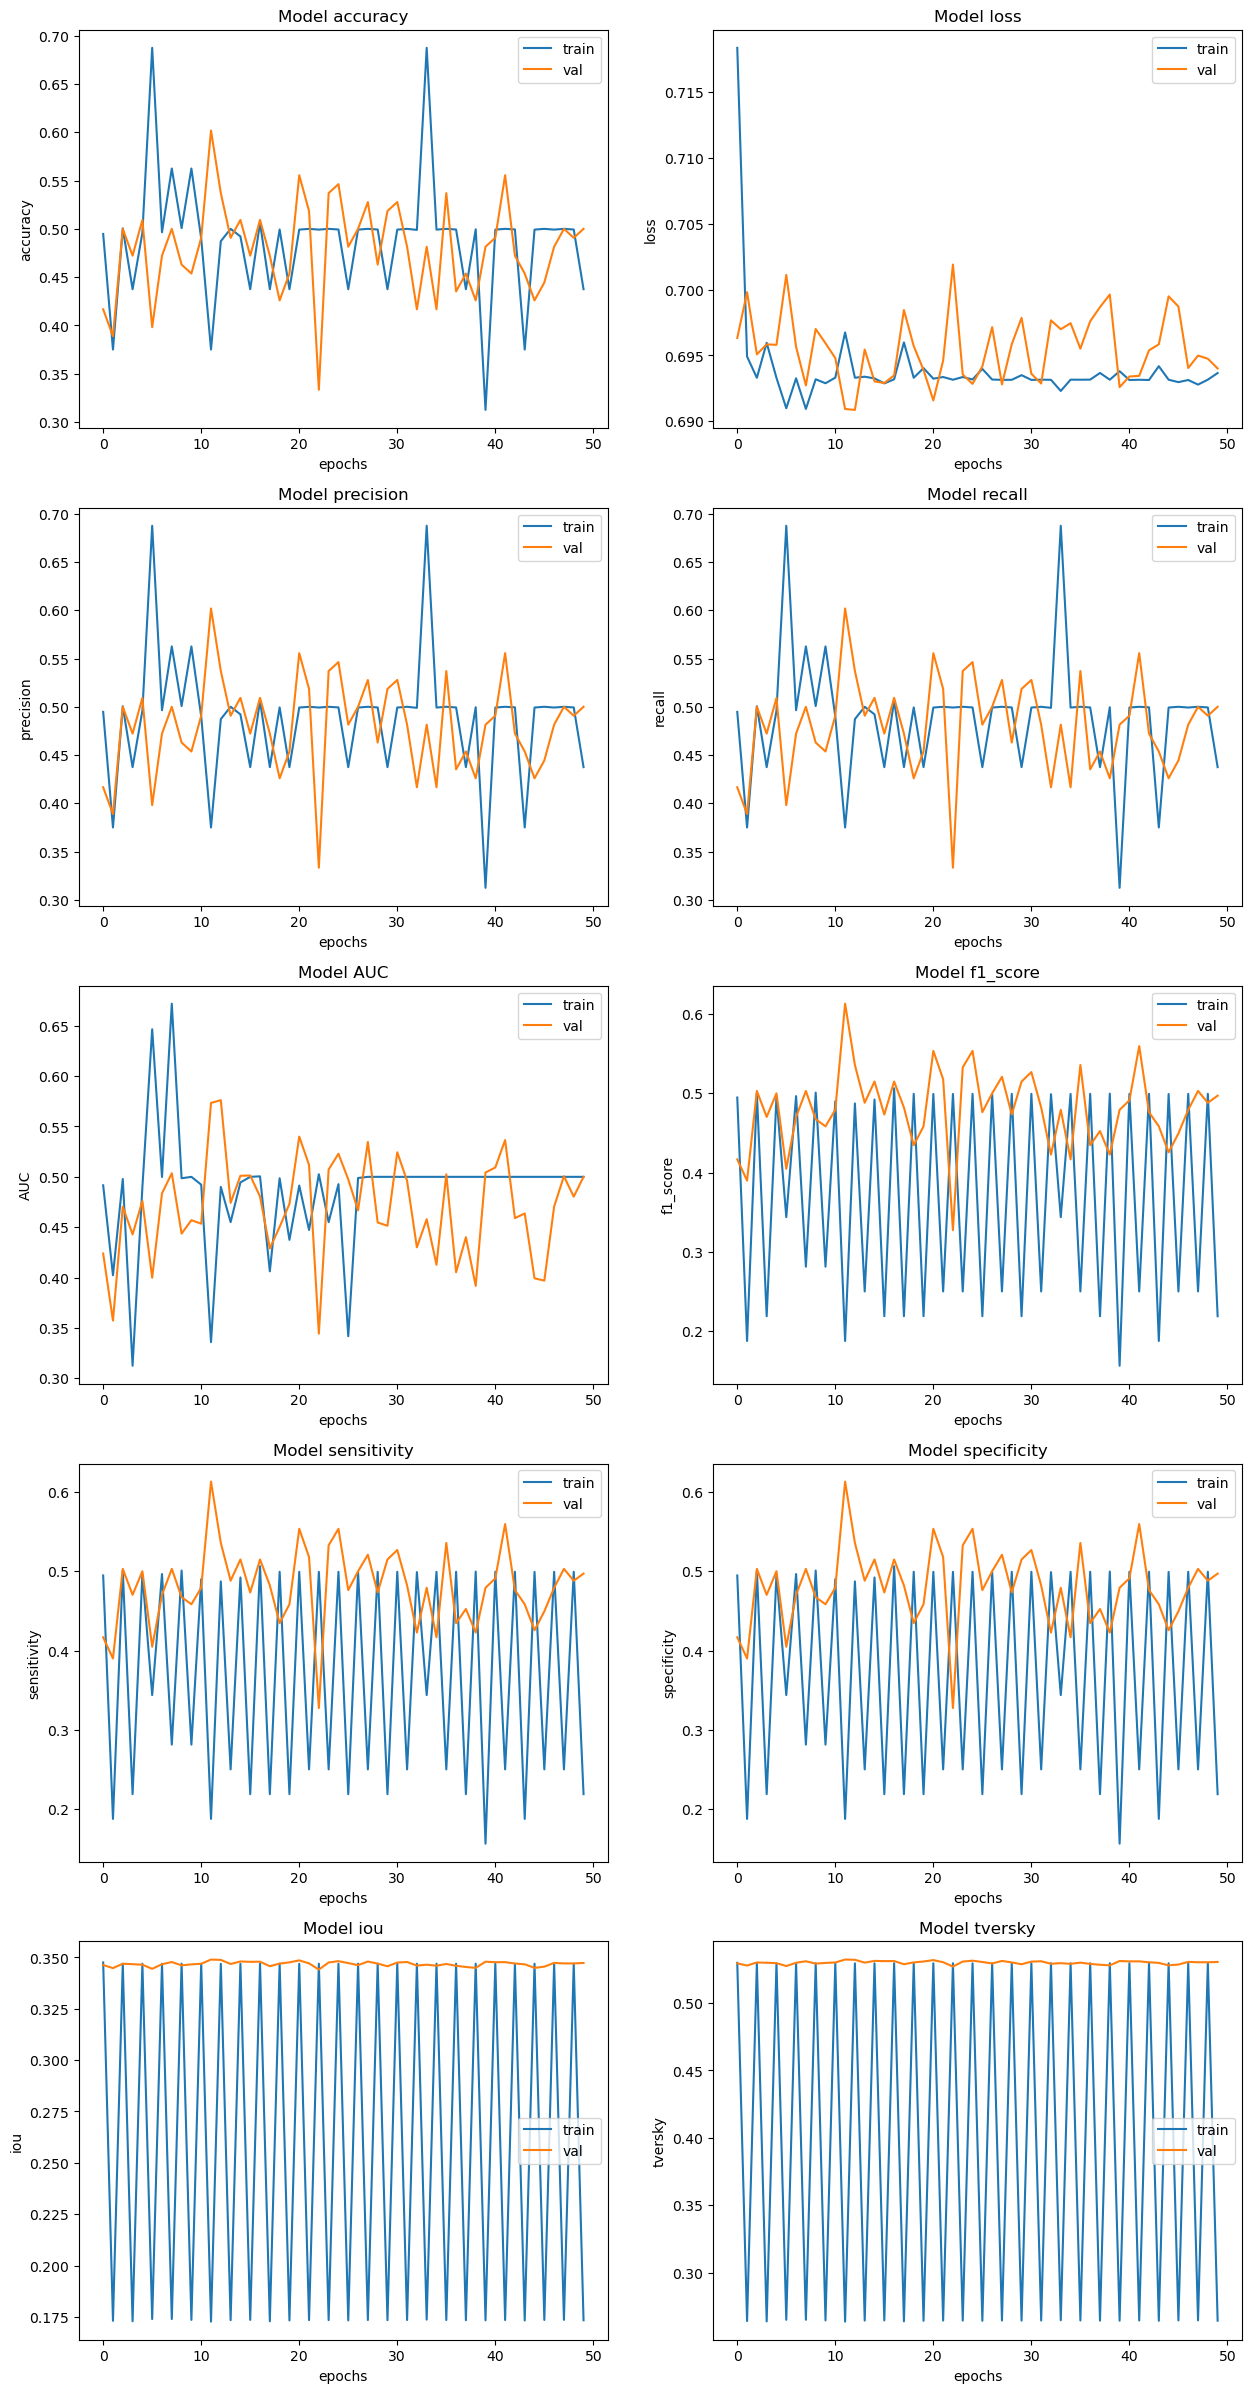

In [7]:
# Interpreting the Metrics
fig, ax = plt.subplots(5, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC', 'f1_score','sensitivity', 'specificity','iou', 'tversky']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-Results.png")

In [9]:
Test_data =(data_gen.flow(X2_test,Y_test,
                                       batch_size=128, 
                                       seed=27,
                                       shuffle=True))

In [11]:
%%time
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(Test_data, batch_size=32, callbacks= callbacks)
print("test loss test acc:", results)

Evaluate on test data


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - AUC: 0.4745 - accuracy: 0.4884 - f1_score: 0.4886 - iou: 0.3345 - loss: 0.6949 - precision: 0.4884 - recall: 0.4884 - sensitivity: 0.4886 - specificity: 0.4886 - tversky: 0.5033
test loss test acc: [0.6948416233062744, 0.48311156034469604, 0.48311156034469604, 0.48311156034469604, 0.4728740453720093, 0.48417001962661743, 0.4841700494289398, 0.4841700494289398, 0.3346638083457947, 0.5035641193389893]
CPU times: user 3min 31s, sys: 3.97 s, total: 3min 35s
Wall time: 29.5 s


In [13]:
truey=[]
predy=[]
x = X2_test
y = Y_test

yhat= model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if(yh[i].index(yy)== yt[i].index(yyt)):
        count+=1

acc = (count/len(y))*100

#saving values for confusion matrix and analysis
np.save('truey', truey)
np.save('predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set :"+str(acc)+"%")

31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 894ms/step
Predicted and true label values saved
Accuracy on test set :52.40532241555783%


Confusion Matrix:
 [[330 170]
 [295 182]]
Classification Report:
               precision    recall  f1-score   support

      benign       0.53      0.66      0.59       500
   malignant       0.52      0.38      0.44       477

    accuracy                           0.52       977
   macro avg       0.52      0.52      0.51       977
weighted avg       0.52      0.52      0.51       977

Accuracy: 0.52
Precision: 0.52
Recall: 0.38
F1 Score: 0.44
Confusion matrix, without normalization
[[330 170]
 [295 182]]


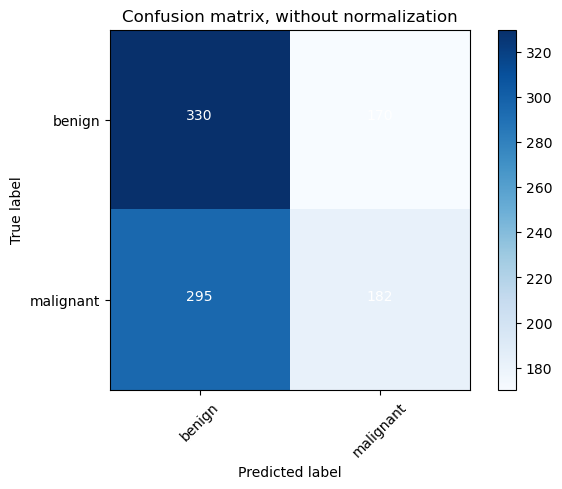

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Flatten, Conv2D, Dropout, BatchNormalization, Activation, Input, UpSampling2D, ZeroPadding2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications import VGG16
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report
import os
from tqdm import tqdm
import shutil
import itertools

# Your previous code goes here

# Assuming truey and predy are the true labels and predicted labels respectively
truey = np.load('truey.npy')
predy = np.load('predy.npy')

# Calculate confusion matrix
cm = confusion_matrix(truey, predy)
print("Confusion Matrix:\n", cm)

# Calculate classification report
report = classification_report(truey, predy, target_names=['benign', 'malignant'])
print("Classification Report:\n", report)

# Display additional metrics
accuracy = np.trace(cm) / float(np.sum(cm))
precision = cm[1,1] / sum(cm[:,1])
recall = cm[1,1] / sum(cm[1,:])
f1 = 2 * precision * recall / (precision + recall)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=['benign', 'malignant'],
                      title='Confusion matrix, without normalization')

plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Reshape, Dense, Flatten, Conv2D, Dropout, BatchNormalization, Activation, Input, UpSampling2D, ZeroPadding2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.applications import VGG16
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import os
from tqdm import tqdm
import shutil
import itertools

# Print TensorFlow and Keras versions
print(tf.__version__)
print(tf.keras.__version__)

# Check GPU status
os.system('nvidia-smi')

# Callbacks
epochs = 50

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_delta=0.0001)
csv_logger = CSVLogger('Model.log')
callbacks = [earlystop, csv_logger, reduce_lr]

# Data Augmentation and Class Balancing
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# GAN Training Loop
epochs = 500
batch_size = 32
save_interval = 1000

# Labels for real and fake images
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

# Load and preprocess the dataset
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

for epoch in range(epochs):

    # Train Discriminator
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # Augment the images
    augmented_imgs = np.array([datagen.random_transform(img) for img in imgs])
    
    # Generate fake images
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(augmented_imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    g_loss = combined.train_on_batch(noise, valid)

    # Print the progress
    if epoch % 100 == 0:
        d_loss_value = np.mean(d_loss)
        d_acc_value = 100 * d_loss_real[1]
        g_loss_value = np.mean(g_loss)
        print(f"{epoch} [D loss: {d_loss_value:.6f}, acc.: {d_acc_value:.2f}%] [G loss: {g_loss_value:.6f}]")

    # Save generated image samples
    if epoch % save_interval == 0:
        noise = np.random.normal(0, 1, (25, latent_dim))
        gen_imgs = generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5, 5)
        cnt = 0
        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[cnt, :, :, :])
                axs[i,j].axis('off')
                cnt += 1
        if not os.path.exists("images"):
            os.makedirs("images")
        fig.savefig(f"images/mnist_{epoch}.png")
        plt.close()

# Using VGG-16 for feature extraction
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(size, size, 3))
for layer in vgg16.layers:
    layer.trainable = False

# Adding custom layers on top of VGG-16
x = vgg16.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs=vgg16.input, outputs=predictions)

# Compile the model
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='AUC'),
                       f1_score, specificity, sensitivity, iou, tversky])

print(model.input_shape)
print(model.output_shape)
model.summary()

# Measure the training time using the time module
import time
start_time = time.time()
history = model.fit(data_gen.flow(X_train, Y_train,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=True),
                    callbacks=callbacks,
                    epochs=50,
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    validation_data=data_gen.flow(X_val, Y_val,
                                       batch_size=batch_size, 
                                       seed=27,
                                       shuffle=True))
end_time = time.time()

print("Training time: {:.2f} seconds".format(end_time - start_time))
model.save("modelBH.h5")
print("Saved model to disk")

df = pd.DataFrame(history.history) 
df.to_excel("output.xlsx")
df.head(50)

# Interpreting the Metrics
fig, ax = plt.subplots(5, 2, figsize=(15, 30))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss', 'precision', 'recall', 'AUC', 'f1_score', 'sensitivity', 'specificity', 'iou', 'tversky']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])
plt.savefig("Model-Results.png")

Test_data = data_gen.flow(X2_test, Y_test,
                          batch_size=128, 
                          seed=27,
                          shuffle=True)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(Test_data, batch_size=32, callbacks=callbacks)
print("test loss test acc:", results)

truey = []
predy = []
x = X2_test
y = Y_test

yhat = model.predict(x)
yh = yhat.tolist()
yt = y.tolist()
count = 0

for i in range(len(y)):
    yy = max(yh[i])
    yyt = max(yt[i])
    predy.append(yh[i].index(yy))
    truey.append(yt[i].index(yyt))
    if yh[i].index(yy) == yt[i].index(yyt):
        count += 1

acc = (count / len(y)) * 100

# Saving values for confusion matrix and analysis
np.save('truey', truey)
np.save('predy', predy)
print("Predicted and true label values saved")
print("Accuracy on test set: " + str(acc) + "%")

confusion_matrix_img(truey, predy, savename='Confusion Matrix')

# Generate classification report
report = classification_report(truey, predy, target_names=['benign', 'malignant'])
print("Classification Report:\n", report)

# Calculate confusion matrix
cm = confusion_matrix(truey, predy)
print("Confusion Matrix:\n", cm)

# Plot the confusion matrix
confusion_matrix_img(truey, predy, savename='Confusion_Matrix.png')
